# Análisis de Subreddits usando Machine Learning
Este notebook implementa:
- Procesamiento de texto con spaCy
- Clasificación de temas usando Naive Bayes y SVM
- Análisis de tendencias con ARIMA y LSTM

In [8]:
# Importar librerías necesarias
import json
import pandas as pd
import numpy as np
import spacy
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Configurar visualización
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class RedditTextProcessor:
    def __init__(self):
        # Inicializar el lematizador
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Preprocesa el texto usando NLTK"""
        # Tokenización
        tokens = word_tokenize(text.lower())
        # Lematización y filtrado de stopwords
        tokens = [
            self.lemmatizer.lemmatize(token) for token in tokens 
            if token.isalpha() and token not in self.stop_words
        ]
        return " ".join(tokens)

    def process_subreddit_data(self, json_file):
        """Procesa el archivo JSON de subreddits"""
        with open(json_file, 'r') as file:
            data = json.load(file)

        processed_posts = []

        for subreddit in data:
            subreddit_name = subreddit['tittleSubreddit']

            for post in subreddit['upVotedPosts']:
                full_text = f"{post['titlePost']} {post['selftext']}"
                processed_text = self.preprocess_text(full_text)

                processed_posts.append({
                    'subreddit': subreddit_name,
                    'processed_text': processed_text,
                    'created_utc': post['createdPost'],
                    'score': post['scorePost'],
                    'upvote_ratio': post['upVotedRatio'],
                    'comments': post['commentsPost']
                })

        return pd.DataFrame(processed_posts)

# Inicializar procesador y cargar datos
text_processor = RedditTextProcessor()
df = text_processor.process_subreddit_data('subreddits.json')
print(f"Datos cargados: {len(df)} posts procesados")
df.head()


Datos cargados: 30000 posts procesados


,subreddit,processed_text,created_utc,score,upvote_ratio,comments
0,Home,mortgage rate,1.713931e+09,22155,0.97,1657
1,Home,parent bought house month ago company flipped ...,1.715981e+09,19059,0.89,5817
2,Home,stuff coming ball noticed something strange co...,1.727928e+09,8121,0.95,1647
3,Home,pella window would ok reacting,1.724790e+09,3531,0.98,1740
4,Home,basement floor leak got quite leak basement fl...,1.721152e+09,1867,0.98,569


## Análisis Exploratorio de Datos

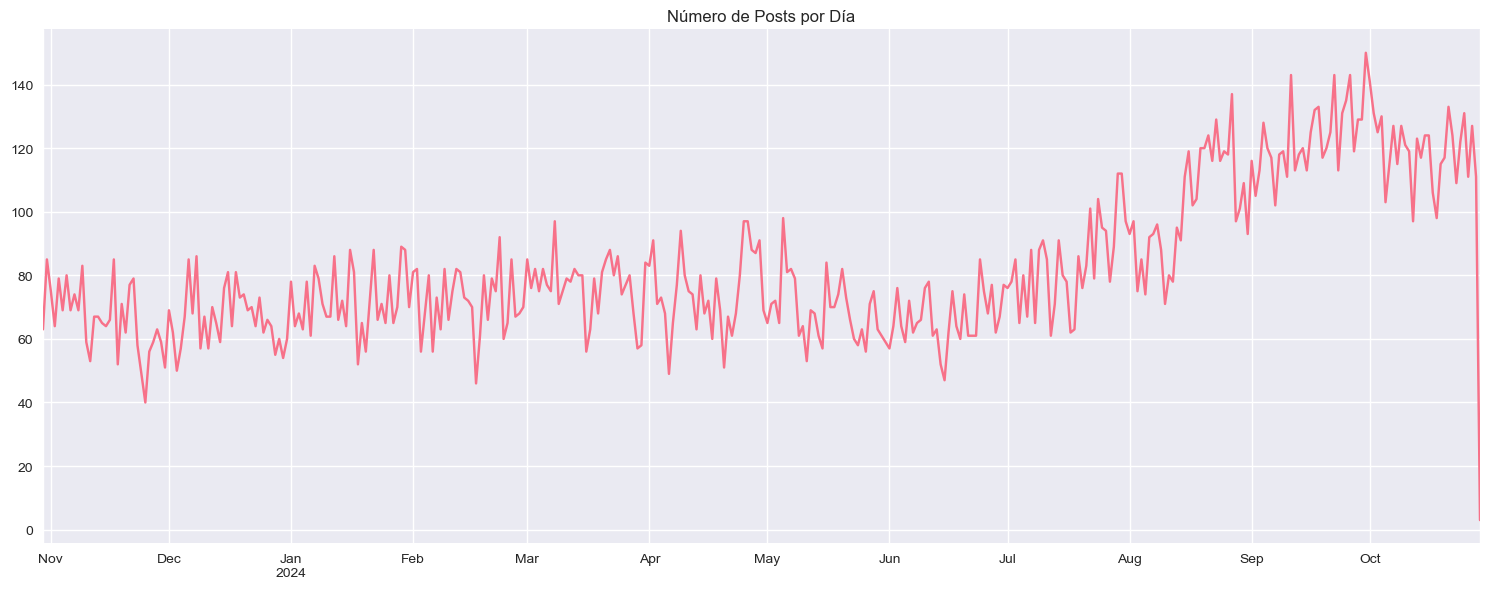

In [23]:
# Visualizar distribución temporal
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s')
postsDay = df['datetime'].dt.date.value_counts().sort_index()
date_range = pd.date_range(start=postsDay.index.min(), end=postsDay.index.max(), freq='D')  
postsDay = postsDay.reindex(date_range, fill_value=0)

plt.figure(figsize=(15, 6))
postsDay.plot(kind='line')
plt.title('Número de Posts por Día')
plt.tight_layout()
plt.show()

## Clasificación de Temas

Resultados de Naive Bayes:
                       precision    recall  f1-score   support

            2007scape       0.47      0.23      0.31        60
                AITAH       0.13      0.25      0.17        57
        AmItheAsshole       0.24      0.50      0.32        60
               AskMen       0.42      0.55      0.47        67
            AskReddit       0.35      0.32      0.33        53
         BaldursGate3       0.23      0.14      0.17        58
             BeAmazed       0.18      0.06      0.09        66
BestofRedditorUpdates       0.08      1.00      0.15        57
   BlackPeopleTwitter       0.17      0.03      0.05        65
              ChatGPT       0.35      0.27      0.31        62
        CombatFootage       0.53      0.79      0.63        62
   CrazyFuckingVideos       0.22      0.07      0.11        68
        CuratedTumblr       0.00      0.00      0.00        63
                  DIY       0.48      0.43      0.45        70
 Damnthatsinteresting      

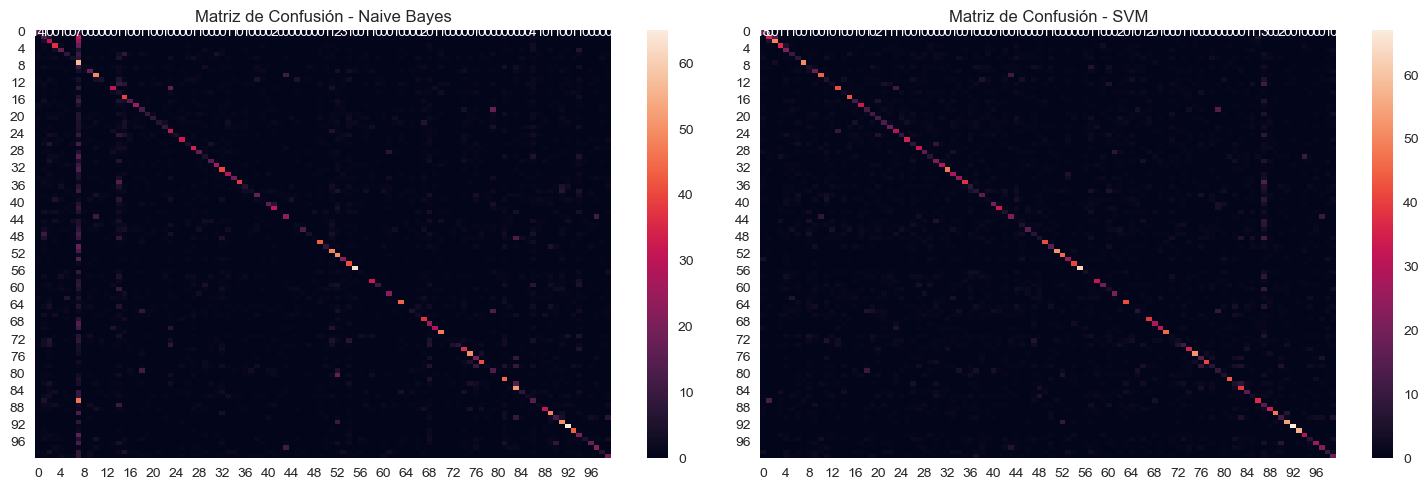

In [14]:
class RedditTopicAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.nb_classifier = MultinomialNB()
        self.svm_classifier = LinearSVC(random_state=42)
        
    def prepare_data(self, df):
        X = self.vectorizer.fit_transform(df['processed_text'])
        y = df['subreddit']
        return train_test_split(X, y, test_size=0.2, random_state=42)
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        # Naive Bayes
        self.nb_classifier.fit(X_train, y_train)
        nb_pred = self.nb_classifier.predict(X_test)
        
        # SVM
        self.svm_classifier.fit(X_train, y_train)
        svm_pred = self.svm_classifier.predict(X_test)
        
        # Visualizar resultados
        print("Resultados de Naive Bayes:")
        print(classification_report(y_test, nb_pred))
        
        print("\nResultados de SVM:")
        print(classification_report(y_test, svm_pred))
        
        # Crear matrices de confusión
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d')
        plt.title('Matriz de Confusión - Naive Bayes')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d')
        plt.title('Matriz de Confusión - SVM')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'nb_accuracy': (nb_pred == y_test).mean(),
            'svm_accuracy': (svm_pred == y_test).mean()
        }

# Entrenar y evaluar modelos
topic_analyzer = RedditTopicAnalyzer()
X_train, X_test, y_train, y_test = topic_analyzer.prepare_data(df)
results = topic_analyzer.train_and_evaluate(X_train, X_test, y_train, y_test)

## Análisis de Tendencias

Entrenando modelo ARIMA...
Entrenando modelo LSTM...





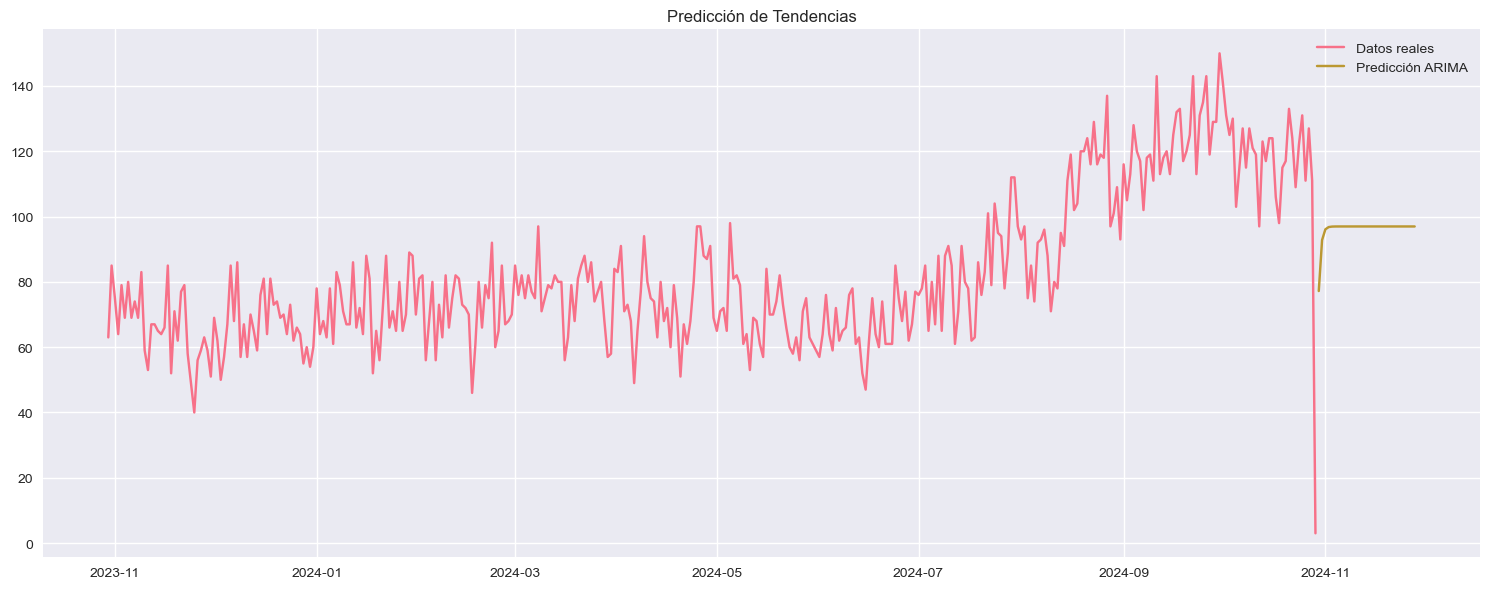

In [15]:
class RedditTrendAnalyzer:
    def __init__(self):
        self.arima_model = None
        self.lstm_model = None
        
    def prepare_time_series(self, df, freq='D'):
        df['datetime'] = pd.to_datetime(df['created_utc'], unit='s')
        daily_posts = df.groupby(pd.Grouper(key='datetime', freq=freq)).size()
        return daily_posts
    
    def fit_arima(self, time_series, order=(1,1,1)):
        self.arima_model = sm.tsa.ARIMA(time_series, order=order)
        self.arima_model = self.arima_model.fit()
        
    def prepare_lstm_data(self, time_series, lookback=10):
        values = time_series.values.reshape(-1, 1)
        generator = TimeseriesGenerator(values, values,
                                      length=lookback,
                                      batch_size=1)
        return generator, values
    
    def build_and_train_lstm(self, generator, lookback=10, epochs=100):
        self.lstm_model = Sequential([
            LSTM(50, activation='relu', input_shape=(lookback, 1)),
            Dense(1)
        ])
        self.lstm_model.compile(optimizer='adam', loss='mse')
        history = self.lstm_model.fit(generator, epochs=epochs, verbose=0)
        return history

# Análisis de tendencias
trend_analyzer = RedditTrendAnalyzer()
time_series = trend_analyzer.prepare_time_series(df)

# ARIMA
print("Entrenando modelo ARIMA...")
trend_analyzer.fit_arima(time_series)
arima_forecast = trend_analyzer.arima_model.forecast(steps=30)

# LSTM
print("Entrenando modelo LSTM...")
generator, values = trend_analyzer.prepare_lstm_data(time_series)
history = trend_analyzer.build_and_train_lstm(generator)

# Visualizar predicciones
plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label='Datos reales')
plt.plot(pd.date_range(time_series.index[-1], periods=31)[1:], 
         arima_forecast, label='Predicción ARIMA')
plt.title('Predicción de Tendencias')
plt.legend()
plt.tight_layout()
plt.show()

## Resultados y Conclusiones

El análisis muestra:
1. Distribución de posts por subreddit
2. Efectividad de los clasificadores (Naive Bayes vs SVM)
3. Predicciones de tendencias futuras

Para mejorar los resultados, podríamos:
- Ajustar hiperparámetros
- Probar diferentes modelos
- Incluir más características en el análisis